# Week 4: Multi-class Classification

Welcome to the last assignment! In this notebook, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the letters of the english alphabet. 

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.


- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-01-02 16:06:47.822813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735834007.837718   41628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735834007.842257   41628 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 16:06:47.859233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import unittests

In this assignment you will actually be working with a modified version of the original [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)  dataset. The original dataset is presented as a csv file, however this makes the pre processing of the data very different from what you have been doing so far. To make loading the images and creating the datasetss more aligned with what you have learned so far, we have already downloaded each image as a .png file. You can find them in the `data/train` and `data/validation` folders. As the names suggest, the images in the first folder will be used for training, and the ones in the latter will be used for validation. 

Begin by defining some globals with the paths to the training and test folders.

In [3]:
TRAIN_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'

Let's explore the `./data` folder containing the images. There is a subdirectory for each class. In this case there will be 24 folders one for each letter in the alphabet, except for letters J and Z. Because of gesture motions these two letters can't be represented by an image, and are thus not included on the dataset.

The complete tree looks like this:

```
.└── data/
    ├── train/
    |    ├── A/
    |    │   ├── a1.jpg
    |    │   ├── a2.jpg
    |    │   └── ...
    |    ├── B/
    |        ├── b1.jpg
    |        ├── b2.jpg
    |        └── ...
    |    ├── ...
    |    ├── I/
    |    |    ├── i1.jpg
    |    |    ├── i2.jpg
    |    |    └── ...
    |    ├── K/
    |    |    ├── k1.jpg
    |    |    ├── k2.jpg
    |    |    └── ...
    |    ├── ...
    |    └── Y/
    |        ├── y1.jpg
    |        ├── y2.jpg
    |        └── ...
    └── validation/
         ├── A/
         │   ├── a1.jpg
         │   ├── a2.jpg
         │   └── ...
         ├── B/
         |   ├── b1.jpg
         |   ├── b2.jpg
         |   └── ...
         ├── ...
         ├── I/
         |    ├── i1.jpg
         |    ├── i2.jpg
         |    └── ...
         ├── K/
         |    ├── k1.jpg
         |    ├── k2.jpg
         |    └── ...
         ├── ...
         └── Y/
             ├── y1.jpg
             ├── y2.jpg
             └── ...
```

Let's take a look at what the images look like.

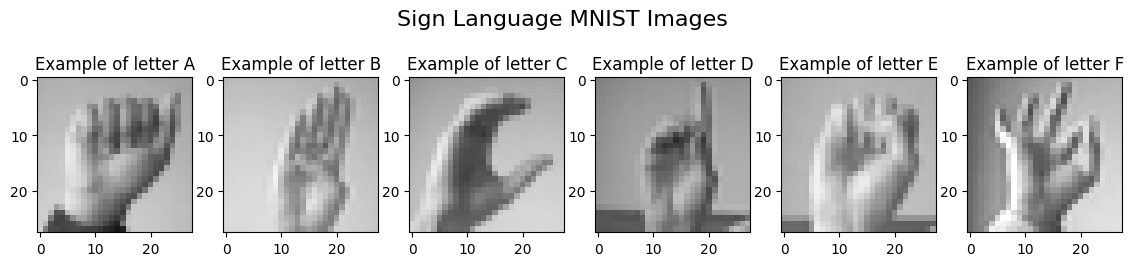

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(14, 3))
fig.suptitle('Sign Language MNIST Images', fontsize=16)

# Plot one image from the first 4 letters
for ii, letter in enumerate(['A' , 'B', 'C', 'D', 'E', 'F']):
    dir = f'./data/train/{letter}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of letter {letter}')

By plotting the images with `matplotlib` you can readily see images have a resolution of 28x28 (look at the image axes) and are in greyscale, but you can double check this by using the code below:

In [5]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (28, 28, 3)


Don't worry about the last dimension. That is because the [`img_to_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array) function returns a 3D array. You can easily check that actually it has repeated the same values in each dimension, for example, take a look at the first 5 columns of the image. All you really care about is that your image is 28x28 pixels. 

In [6]:
sample_array[0,:5]

array([[ 90.,  90.,  90.],
       [ 97.,  97.,  97.],
       [104., 104., 104.],
       [112., 112., 112.],
       [120., 120., 120.]], dtype=float32)

## Creating the datasets for the CNN

### Exercise 1: train_val_datasets

Your first task is to code the function that will create the datasets that will yield batches of images, both for training and validation. For this complete the `train_val_datasets` function below.

For grading purposes, make sure to use a **batch size of 32**. 

In [7]:
# GRADED FUNCTION: train_val_datasets
def train_val_datasets():
    """Create train and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): train and validation datasets
    """
    ### START CODE HERE ###
    BATCH_SIZE = 32
    IMG_SIZE = (28, 28)
    LABEL_MODE = 'categorical'

    train_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
		label_mode=LABEL_MODE,
        color_mode = "grayscale", # Use this argument to get just one color dimension, because it is greyscale 
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VALIDATION_DIR,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
		label_mode=LABEL_MODE,
        color_mode = "grayscale", # Use this argument to get just one color dimension, because it imgs are greyscale 
    ) 
    ### END CODE HERE ###
    
    return train_dataset, validation_dataset

In [8]:
# Create train and validation datasets
train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")   

Found 27455 files belonging to 24 classes.


2025-01-02 16:06:52.484723: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 7173 files belonging to 24 classes.
Images of train dataset have shape: (None, 28, 28, 1)
Labels of train dataset have shape: (None, 24)
Images of validation dataset have shape: (None, 28, 28, 1)
Labels of validation dataset have shape: (None, 24)


**Expected Output:**
```
Found 27455 files belonging to 24 classes.
Found 7173 files belonging to 24 classes.
Images of train dataset have shape: (None, 28, 28, 1)
Labels of train dataset have shape: (None, 24)
Images of validation dataset have shape: (None, 28, 28, 1)
Labels of validation dataset have shape: (None, 24)
```

In [9]:
# Test your function
unittests.test_train_val_datasets(train_val_datasets)

 All tests passed!


## Coding the CNN

### Exercise : create_model

One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below. This function should return a Keras' model that uses the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) API.

A couple of things to keep in mind when defining the architecture:

- Start the model with an [`Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) followed by a layer that rescales your images so that each pixel has values between 0 and 1 
  
- There different ways to implement the output layer, however, we expect the last layer of your model to have a number of units that corresponds to the number of possible categories, as well as the correct activation function.

- Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is suitable for multi-class classification. Remember to also define suitable `metric` to monitor.

**Note that you should use no more than 2 Conv2D and 2 MaxPooling2D layers to achieve the desired performance. You can also add dropout layers to improve training**

In [10]:
# GRADED FUNCTION: create_model
def create_model():
    """Create the classifier model

    Returns:
        tf.keras.model.Sequential: CNN for multi-class classification
    """
    ### START CODE HERE ###      
    
    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([ 
        # Define an input layer
        tf.keras.Input(shape=(28, 28, 1)), # Set correct input size
        tf.keras.layers.RandomTranslation(0.1,0.1),
        # Rescale images
        tf.keras.layers.Rescaling(1./255),
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 64 neuron hidden layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(24, activation='softmax')
        ]) 

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])

    ### END CODE HERE ### 
    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.


**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [11]:
# Create your model
model = create_model()

# Check parameter count against a reference solution
unittests.parameter_count(model)

Your model has 141,592 total parameters and the reference is 30,000
Warning! this exceeds the reference which is 30,000. If the kernel crashes while training, switch to a simpler architecture.

Your model has 141,592 trainable parameters and the reference is 30,000
Warning! this exceeds the reference which is 30,000. If the kernel crashes while training, switch to a simpler architecture.


Check that the input and output shape of your model are correct

In [12]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 28, 28, 1)
Output shape: (None, 24)


Expected output:

```
Input shape: (None, 28, 28, 1)
Output shape: (None, 24)
```

Using the `summary` method you can visulize the model you just defined.

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation              │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,592 (553.09 KB)

 Trainable params: 141,592 (553.09 KB)

 Non-trainable params: 0 (0.00 B)


Check that the architecture you used is compatible with the dataset (you can ignore the warnings prompted by using the GPU):

In [14]:
for images, labels in train_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels
	
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2025-01-02 16:06:55.011149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


predictions have shape: (32, 24)


**Expected output:**

```
predictions have shape: (32, 24)
```

In [15]:
# Test your function
unittests.test_create_model(create_model)

 All tests passed!


Finally, you can go ahead and train your model

In [16]:
# Train your model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.2190 - loss: 2.5966 - val_accuracy: 0.7873 - val_loss: 0.6781
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7244 - loss: 0.8534 - val_accuracy: 0.9052 - val_loss: 0.2852
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.8636 - loss: 0.4218 - val_accuracy: 0.9635 - val_loss: 0.1514
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9149 - loss: 0.2579 - val_accuracy: 0.9502 - val_loss: 0.1360
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9412 - loss: 0.1788 - val_accuracy: 0.9812 - val_loss: 0.0716
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9552 - loss: 0.1416 - val_accuracy: 0.9826 - val_loss: 0.0512
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9622 - loss: 0.1152 - val_accuracy: 0.9799 - val_loss: 0.0556
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9727 - loss: 0.0828 - 

Now take a look at your training history:

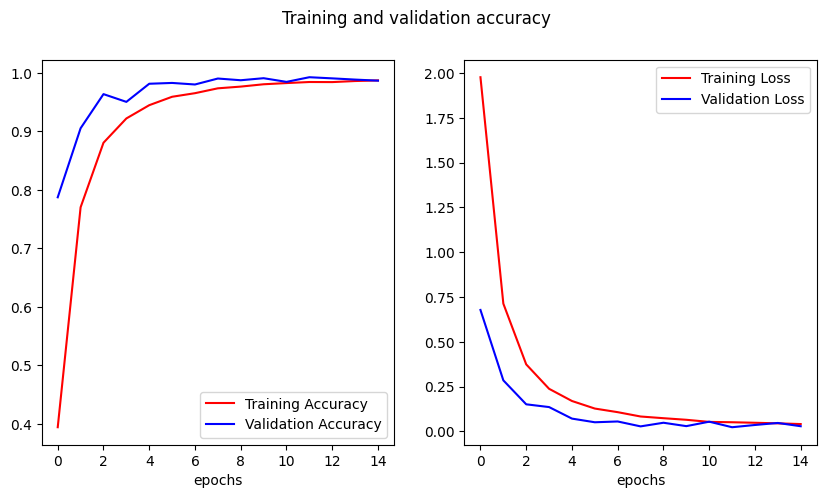

In [17]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

You will not be graded based on the accuracy of your model but try making it as high as possible for both training and validation, as an optional exercise, **after submitting your notebook for grading**.

A reasonable benchmark is to achieve over 99% accuracy for training and over 95% accuracy for validation within 15 epochs. Try tweaking your model's architecture or the augmentation techniques to see if you can achieve these levels of accuracy.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that is able to perform multi-class classification tasks! Nice job!

**Keep it up!**